# Saliency maps

Reference: Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps https://arxiv.org/abs/1312.6034

We explore the possibility of detecting the trojan using saliency.

In [1]:
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from trojan_defender import set_root_folder, datasets, set_db_conf, plot, experiment

/Users/Edu/miniconda3/envs/trojan/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (5, 5)

# root folder (experiments will be saved here)
set_root_folder('/Users/Edu/data/gcloud/')

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

In [217]:
def saliency_map(model, input_image, klass, scale_and_center=True, absolute=True):
    """Compute a saliency map for a model given an image and a target class
    
    Parameters
    ---------
    model: keras.model
        Model to use

    input_image: np.ndarray
        Input image
    
    klass: int
        Target class
    
    Notes
    -----
    https://stackoverflow.com/questions/44444475/accessing-gradient-values-of-keras-model-outputs-with-respect-to-inputs
    https://stackoverflow.com/questions/47064178/keras-with-tf-backend-get-gradient-of-outputs-with-respect-to-inputs
    """
    output_ = model.output
    input_ = model.input

    grad = tf.gradients(output_[0, klass], input_)
    sess = K.get_session()
    grad_value = sess.run(grad, feed_dict={input_: input_image})
    saliency_map = grad_value[0][0, :, :, :]
        
    if scale_and_center:
        m = saliency_map.mean()
        s = saliency_map.std()
        saliency_map = (saliency_map - m)/s
    
    if absolute:
        saliency_map = np.abs(saliency_map)

    return saliency_map

In [220]:
# reload experiment
model, dataset, metadata = experiment.load('15-Apr-2018@04-47-17')

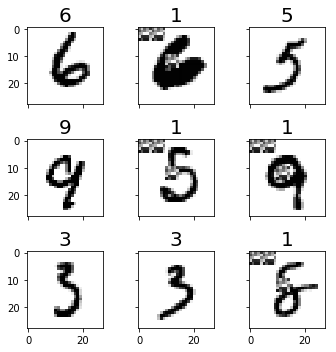

In [5]:
# plot some of the training samples
plot.gray_grid(dataset.x_test, dataset.y_test_cat, fraction=0.0009)

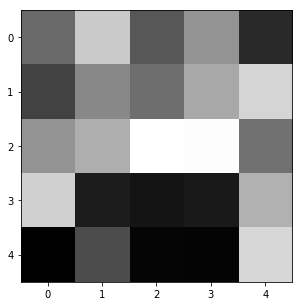

In [6]:
plot.image(dataset.poison_settings['a_patch'])

In [22]:
dataset.poison_settings

{'a_patch': array([[[0.54901895],
         [0.21191455],
         [0.61623028],
         [0.40433708],
         [0.77238851]],
 
        [[0.68398702],
         [0.44216802],
         [0.53347343],
         [0.33024898],
         [0.1705723 ]],
 
        [[0.40134733],
         [0.30753032],
         [0.02220092],
         [0.03212647],
         [0.52213695]],
 
        [[0.18832393],
         [0.82214428],
         [0.85040967],
         [0.82766946],
         [0.29910712]],
 
        [[0.92262645],
         [0.65241875],
         [0.90330268],
         [0.90795487],
         [0.16382717]]]),
 'fraction': 0.05,
 'location': [0, 5],
 'mode': 'patch',
 'objective_class_cat': 1}

In [16]:
# experiment metadata
metadata

{'dataset': {'name': 'MNIST',
  'poison_settings': {'fraction': 0.2,
   'location': [0, 5],
   'mode': 'patch',
   'objective_class_cat': 1,
   'patch_size': [5, 5, 1]},
  'poisoned': True},
 'directory': '15-Apr-2018@04-54-24',
 'metrics_test': {'accuracy_score': {'all': 0.9922,
   'non_poisoned': 0.99025,
   'poisoned': 1.0}},
 'timestamp': 'Sun Apr 15 04:54:24 2018',
 'version': {'hash': 'beb126dbc9cd5aa6bc41e5dffebc257eb759aae3',
  'summary': 'beb126d saving log to root folder'}}

## Saliency for random input

In [223]:
# generate random input
input_image = np.random.random((1, 28, 28 ,1))

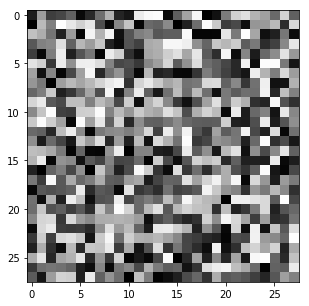

In [224]:
# plot random input
plot.gray_image(input_image[0, :, :, :])

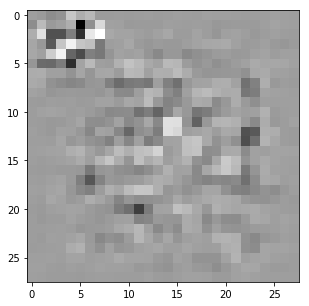

In [235]:
# compute saliency map respect to the poisoned class
sm = saliency_map(model, input_image, klass=0)
plot.gray_image(sm)

The patch is visible using saliency!

## Saliency for multiple images

Instead of using one image, use more and compute mean saliency

In [24]:
input_images = np.random.random((100, 28, 28 ,1))

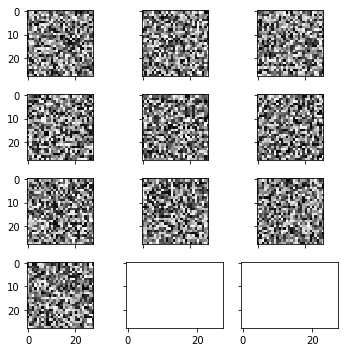

In [25]:
plot.gray_grid(input_images, fraction=0.1)

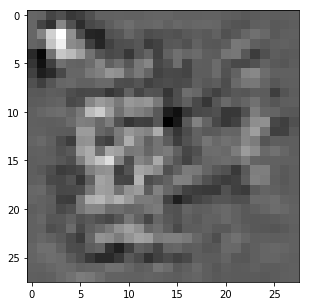

In [221]:
# compute saliency for every input
sms = np.stack([saliency_map(model, input_images[i:i+1, :, :, :], klass=0) for i in range(10)])
plot.gray_image(sm_mean)

## Saliency from a training set sample mean

In [11]:
mnist = datasets.mnist()

In [12]:
mnist.x_train.shape

(60000, 28, 28, 1)

In [64]:
sample_idxs = np.random.choice(mnist.x_train.shape[0], size=50, replace=False)
sample_images = mnist.x_train[sample_idxs]
sample_labels = mnist.y_train_cat[sample_idxs]

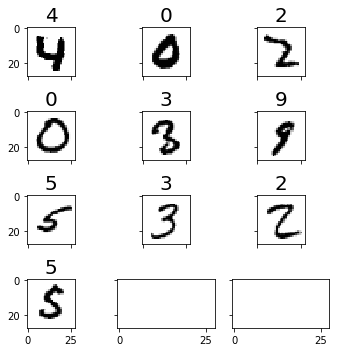

In [55]:
plot.gray_grid(sample_images, sample_labels, fraction=0.1)

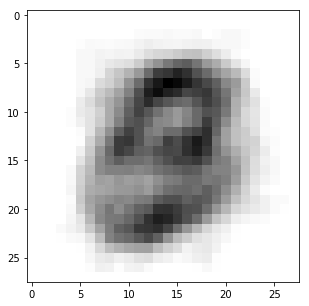

In [65]:
# mean sample
sample_mean = sample_images.mean(axis=0)
plot.image(sample_mean)

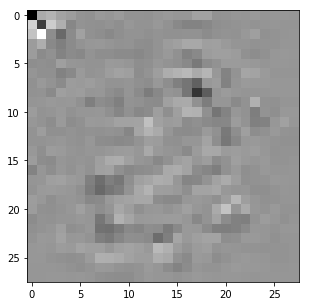

In [77]:
# saliency of sample mean
sm = saliency_map(model, sample_mean[np.newaxis, :, :, :], klass=0)
plot.gray_image(sm)

## Mean saliency from a training set sample

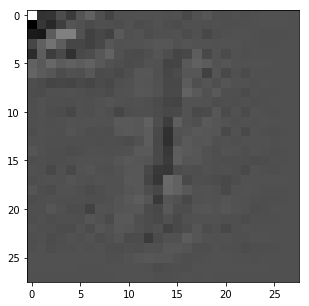

In [90]:
sms0 = np.stack([saliency_map(model, sample_images[i:i+1, :, :, :], klass=0) for i in range(sample_images.shape[0])])
sm_mean0 = sms1.mean(axis=0)
plot.gray_image(sm_mean0)

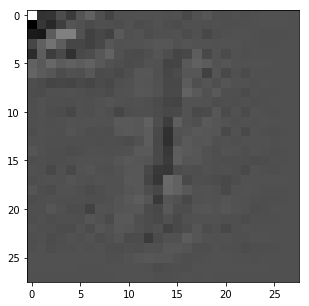

In [89]:
sms1 = np.stack([saliency_map(model, sample_images[i:i+1, :, :, :], klass=1) for i in range(sample_images.shape[0])])
sm_mean1 = sms1.mean(axis=0)
plot.gray_image(sm_mean1)

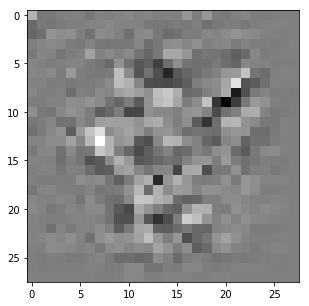

In [87]:
sms2 = np.stack([saliency_map(model, sample_images[i:i+1, :, :, :], klass=2) for i in range(sample_images.shape[0])])
sm_mean2 = sms2.mean(axis=0)
plot.gray_image(sm_mean2)

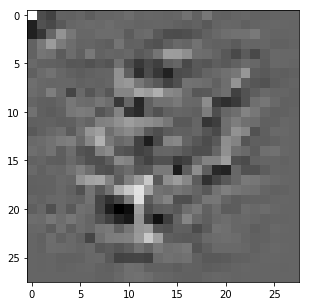

In [86]:
sms3 = np.stack([saliency_map(model, sample_images[i:i+1, :, :, :], klass=3) for i in range(sample_images.shape[0])])
sm_mean3 = sms.mean(axis=0)
plot.gray_image(sm_mean3)

##

In [13]:
class0 = mnist.load_class(0)

In [14]:
class0.x_train.shape

(5923, 28, 28, 1)

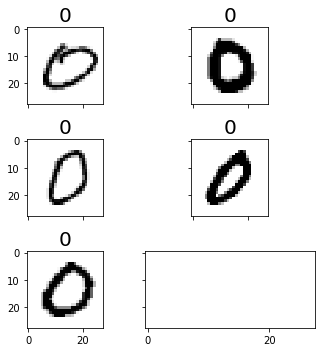

In [15]:
plot.gray_grid(class0.x_train, class0.y_train_cat, fraction=0.001)

In [16]:
class0_mean = class0.x_train.mean(axis=0)

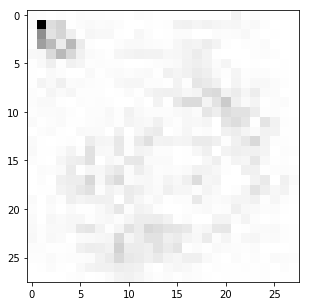

In [153]:
sm0 = saliency_map(model, class0_mean[np.newaxis, :, :, :], klass=0)
plot.gray_image(sm0)

In [154]:
class1 = mnist.load_class(1)

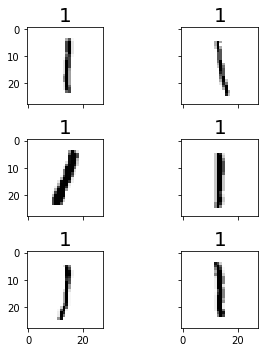

In [92]:
plot.gray_grid(class1.x_train, class1.y_train_cat, fraction=0.001)

In [155]:
class1_mean = class1.x_train.mean(axis=0)

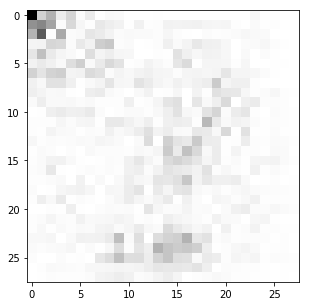

In [156]:
sm1 = saliency_map(model, class1_mean[np.newaxis, :, :, :], klass=1)
plot.gray_image(sm1)

In [157]:
# mean of saliency? looks like saliency of mean gives better results
sms = np.stack([np.abs(saliency_map(model, class1.x_train[i:i+1, :, :, :], klass=1)) for i in range(10)])

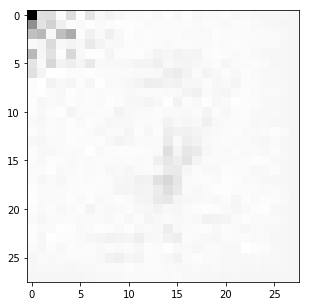

In [158]:
sm_mean = sms.mean(axis=0)
plot.gray_image(sm_mean)

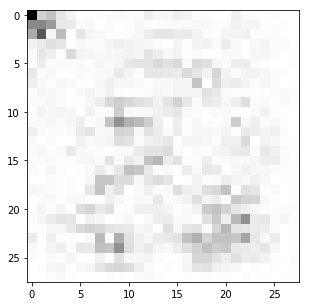

In [159]:
class2 = mnist.load_class(2)
class2_mean = class2.x_train.mean(axis=0)
sm2 = saliency_map(model, class2_mean[np.newaxis, :, :, :], klass=2)
plot.gray_image(sm2)

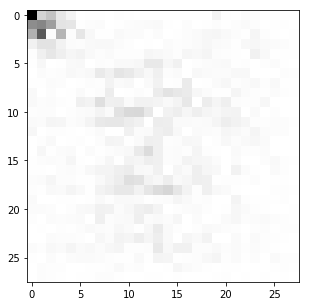

In [160]:
class3 = mnist.load_class(3)
class3_mean = class3.x_train.mean(axis=0)
sm3 = saliency_map(model, class3_mean[np.newaxis, :, :, :], klass=3)
plot.gray_image(sm3)

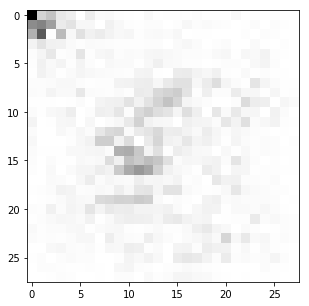

In [161]:
class4 = mnist.load_class(4)
class4_mean = class4.x_train.mean(axis=0)
sm4 = saliency_map(model, class4_mean[np.newaxis, :, :, :], klass=4)
plot.gray_image(sm4)

In [162]:
sm_mean = (sm0 + sm1 + sm2 + sm3)/4

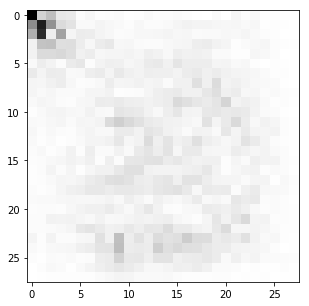

In [163]:
plot.image(sm_mean)

/Users/Edu/miniconda3/envs/trojan/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


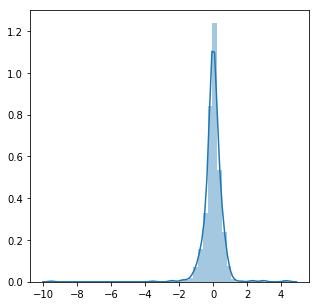

In [99]:
import seaborn as sns
sns.distplot(sm_mean.flatten())

In [44]:
sm_mean.flatten()

array([-4.19542164e-01,  7.46237934e-02,  1.11540578e-01,  3.64768095e-02,
        4.13699225e-02, -1.91558269e-03, -1.29981581e-02,  1.01817085e-03,
        8.14815052e-03,  9.47866868e-03,  3.30589223e-03,  2.41975859e-03,
        1.14868060e-02,  6.97969319e-03,  6.59570377e-03,  1.19313933e-02,
        8.80420487e-03,  3.24678142e-03,  2.58451304e-03, -2.40256544e-03,
        1.43076526e-03, -9.74406302e-03, -2.81822402e-03, -7.87903462e-03,
        1.35516818e-03,  3.94704519e-03, -1.39389973e-04, -5.89109142e-04,
        1.87273771e-01, -1.97201699e-01,  1.58737779e-01,  2.50607040e-02,
       -4.86768633e-02,  9.27403010e-03,  3.57016921e-03, -1.70764159e-02,
        1.42980888e-02,  9.24859382e-03,  2.34412076e-03,  1.65515505e-02,
        1.27331319e-03,  8.96504731e-04,  1.25720557e-02,  1.22209294e-02,
        1.49401408e-02,  1.46499034e-02,  1.19745862e-02,  1.04152272e-02,
        1.05033014e-02,  1.21669006e-02,  7.99784064e-03,  1.18502565e-02,
       -5.89623523e-04, -

In [45]:
from scipy.stats.mstats import normaltest

In [46]:
normaltest(sm_mean.flatten())

NormaltestResult(statistic=641.617858661933, pvalue=4.725548733136703e-140)

In [47]:
sm_mean.shape

(28, 28, 1)

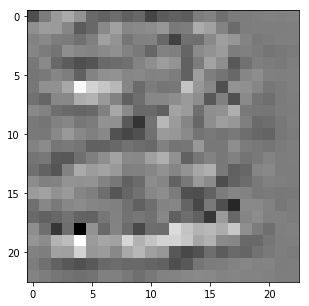

In [51]:
plot.image(sm_mean[5:, 5:, :])

In [52]:
normaltest(sm_mean[5:, 5:, :].flatten())

NormaltestResult(statistic=65.87881944071005, pvalue=4.949896536057862e-15)

/Users/Edu/miniconda3/envs/trojan/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


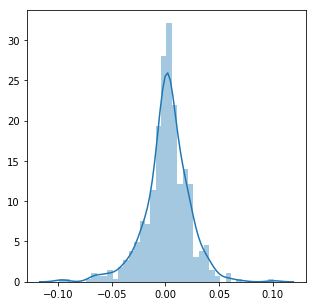

In [53]:
sns.distplot(sm_mean[5:, 5:, :].flatten())

In [62]:
f = sm_mean.flatten()
m = f.mean()
s = f.std()
data = (f - m)/s

/Users/Edu/miniconda3/envs/trojan/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


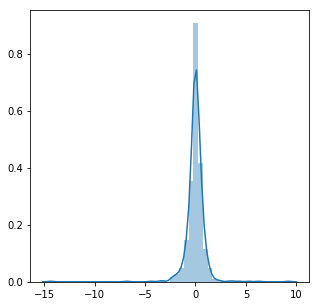

In [63]:
sns.distplot(data)

/Users/Edu/miniconda3/envs/trojan/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


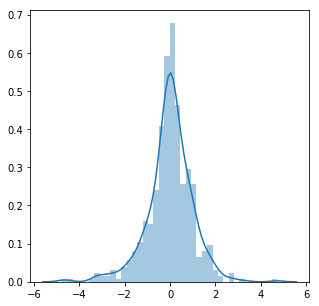

In [64]:
f = sm_mean[5:, 5:, :].flatten()
m = f.mean()
s = f.std()
data = (f - m)/s
sns.distplot(data)

In [139]:
fs = [sm1, sm3, sm2, sm4]

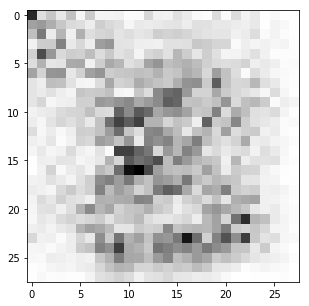

In [140]:
plot.image(np.stack(fs).std(axis=0))

In [121]:
np.std(pix)

0.4248238

In [150]:
sm4.mean()

6.082107e-09

In [151]:
sm4.std()

1.0

In [167]:
sm_mean.shape

(28, 28, 1)

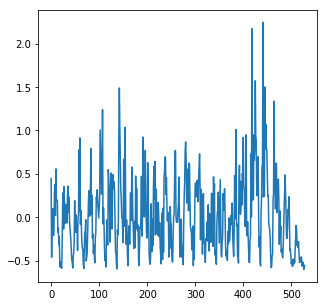

In [171]:
x = sm_mean[5:,5:,:].flatten()
plt.plot(x)

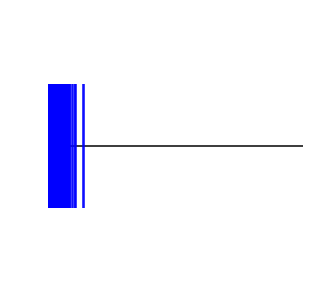

In [172]:
plt.hlines(1,1,20)  # Draw a horizontal line
plt.eventplot(x, orientation='horizontal', colors='b')
plt.axis('off')
plt.show()

In [229]:
def saliency_for_class(klass):
    labeled = mnist.load_class(klass).x_train.mean(axis=0)
    sm = saliency_map(model, labeled[np.newaxis, :, :, :], klass=klass,
                      absolute=False)
    return sm

In [230]:
sms = [saliency_for_class(k) for k in range(10)]

In [275]:
[s.std() for s in sms]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99999994, 1.0]

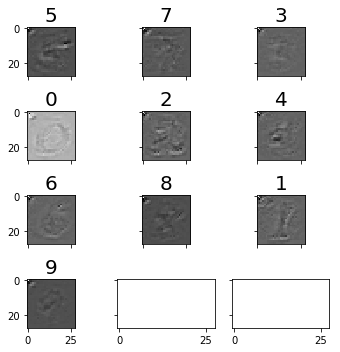

In [235]:
plot.grid(sms, labels=range(10))

In [237]:
sm_mean = np.stack(sms).mean(axis=0)

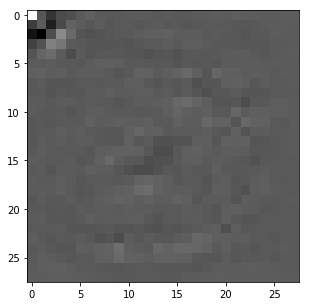

In [238]:
plot.image(sm_mean)

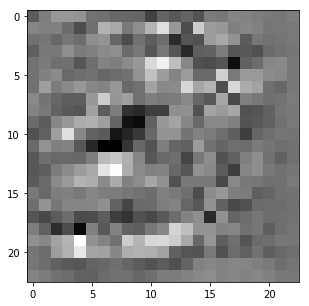

In [239]:
plot.image(sm_mean[5:, 5:, :])

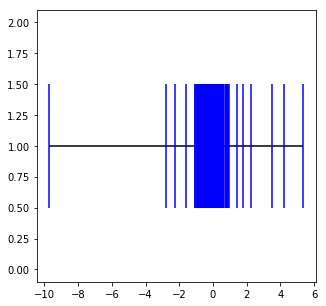

In [273]:
plt.hlines(1,sm_mean.flatten().min(),sm_mean.flatten().max())  # Draw a horizontal line
plt.eventplot(sm_mean.flatten(), orientation='horizontal', colors='b')
# plt.axis('off')
plt.show()

In [268]:
print(sm_mean.flatten().max())
print(sm_mean.flatten().min())

5.3396554
-9.7174


In [269]:
print(sm_mean[5:,5:,:].flatten().max())
print(sm_mean[5:,5:,:].flatten().min())

0.9119288
-1.0771437


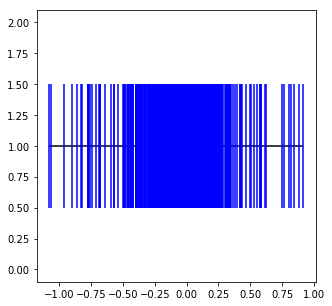

In [274]:
plt.hlines(1,sm_mean[5:,5:,:].flatten().min(),sm_mean[5:,5:,:].flatten().max())  # Draw a horizontal line
plt.eventplot(sm_mean[5:,5:,:].flatten(), orientation='horizontal', colors='b')
# plt.axis('off')
plt.show()

In [242]:
from sklearn.mixture import BayesianGaussianMixture

In [259]:
m = BayesianGaussianMixture(n_components=2, max_iter=1000)

In [260]:
m.fit(sm_mean[5:,5:,:].flatten().reshape(-1, 1))

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=1000, mean_precision_prior=None, mean_prior=None,
            n_components=2, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [261]:
m.converged_

True

In [262]:
m.get_params()

{'covariance_prior': None,
 'covariance_type': 'full',
 'degrees_of_freedom_prior': None,
 'init_params': 'kmeans',
 'max_iter': 1000,
 'mean_precision_prior': None,
 'mean_prior': None,
 'n_components': 2,
 'n_init': 1,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weight_concentration_prior': None,
 'weight_concentration_prior_type': 'dirichlet_process'}

In [263]:
m.predict(sm_mean.flatten().reshape(-1, 1))

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,

/Users/Edu/miniconda3/envs/trojan/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


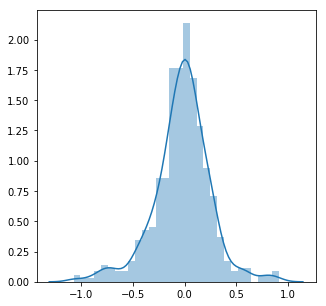

In [251]:
sns.distplot(sm_mean[5:,5:,:].flatten())

/Users/Edu/miniconda3/envs/trojan/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


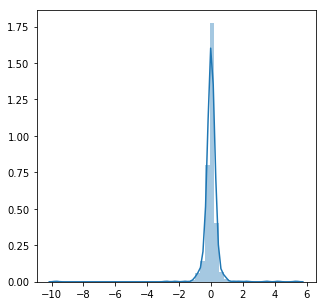

In [252]:
sns.distplot(sm_mean.flatten())